In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from geopy.distance import great_circle
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_base, tqdm_notebook as tqdm

tqdm_base.pandas()

# installing geopandas on mac with conda is a pain, i recommend starting with a fresh conda env and...
# pip install geopandas numpy pandas shapely fiona six pyproj tables matplotlib tqdm

In [2]:
# because jan 18 is split across 2 gtfs feeds (https://transitfeeds.com/p/king-county-metro/)
# let's verify that route_id for D and E are consistent
# i downloaded/unzipped gtfs into ./data/source/gtfs_YYYYMMDD dirs
#routes_1 = pd.read_csv('./data/source/gtfs_20171116/routes.txt')
routes_2 = pd.read_csv('./data/source/gtfs_20180118/routes.txt')

In [3]:
#routes_1[(routes_1.route_short_name == 'D Line') | (routes_1.route_short_name == 'E Line')]

In [4]:
routes_2[(routes_2.route_short_name == 'D Line') | (routes_2.route_short_name == 'E Line')]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
202,102581,KCM,D Line,NaN,Blue Ridge/Crown Hill - Ballard - Downtown Sea...,3,http://metro.kingcounty.gov/schedules/674/n0.html,NaN,NaN
205,102615,KCM,E Line,NaN,Aurora Village Transit Center - Downtown Seattle,3,http://metro.kingcounty.gov/schedules/675/n0.html,NaN,NaN


In [5]:
# route_id is unchanged
# D line = 102581
# E line = 102615

In [6]:
locations_df = pd.read_hdf('./data/intermed/positions_201801.h5', key='df')

In [7]:
# D Line
locations_df[locations_df.route_id == 102581].shape

(167619, 8)

In [8]:
#E Line
locations_df[locations_df.route_id == 102615].shape

(197432, 8)

In [9]:
# For the D, focus on this segment:
# 1). Pine to 1st N/Key Arena

In [10]:
dline_df = locations_df[locations_df.route_id == 102581]

In [11]:
dline_df.head()

,route_id,timestamp,trip_id,vehicle_id,vehicle_lat,vehicle_long,time_utc,time_pct
timestamp_utc,,,,,,,,
2017-12-31 23:58:01,102581,1514764681,34921951,6069,47.702541,-122.363777,2017-12-31 23:58:01,2017-12-31 15:58:01-08:00
2017-12-31 23:58:21,102581,1514764701,34921948,6065,47.613445,-122.342667,2017-12-31 23:58:21,2017-12-31 15:58:21-08:00
2017-12-31 23:58:45,102581,1514764725,34921896,6093,47.649120,-122.376137,2017-12-31 23:58:45,2017-12-31 15:58:45-08:00
2017-12-31 23:59:07,102581,1514764747,34921897,6203,47.620068,-122.355438,2017-12-31 23:59:07,2017-12-31 15:59:07-08:00
2017-12-31 23:59:24,102581,1514764764,34921950,6205,47.680241,-122.376770,2017-12-31 23:59:24,2017-12-31 15:59:24-08:00


In [12]:
trips_df = pd.read_csv('./data/source/gtfs_20180118/trips.txt')
shapes_df = pd.read_csv('./data/source/gtfs_20180118/shapes.txt')

In [13]:
# It appears that direction_id = 0 for the D is northbound because trip_headsign = "Ballard Uptown" 
# vs. trip_headsign = "Downtown Seattle Uptown" when direction_id = 1.
trips_df[(trips_df.route_id == 102581) & (trips_df.direction_id == 0)].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12146,102581,66726,34815377,Ballard Uptown,LOCAL,0,4759512,11674003,0,101.0
12147,102581,66726,34815378,Ballard Uptown,LOCAL,0,4759514,11674003,0,101.0
12148,102581,66726,34815379,Ballard Uptown,LOCAL,0,4759517,11674003,0,101.0
12149,102581,66726,34815380,Ballard Uptown,LOCAL,0,4759510,11674003,1,110.0
12150,102581,66726,34815381,Ballard Uptown,LOCAL,0,4759516,11674003,1,110.0


In [14]:
d_shape = shapes_df[shapes_df.shape_id == 11674003].copy()

In [15]:
d_shape.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
112745,11674003,47.601669,-122.330170,1,0.0
112746,11674003,47.601719,-122.330269,2,30.0
112747,11674003,47.601761,-122.330391,3,64.5
112748,11674003,47.601830,-122.330498,4,100.1
112749,11674003,47.601936,-122.330650,5,153.5


In [16]:
#list(zip(d_shape.shape_pt_lon, d_shape.shape_pt_lat))

In [17]:
d_shape['coordinates'] = list(zip(d_shape.shape_pt_lon, d_shape.shape_pt_lat))
d_shape['coordinates'] = d_shape['coordinates'].apply(Point)

In [18]:
d_shape

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coordinates
112745,11674003,47.601669,-122.330170,1,0.0,POINT (-122.33017 47.6016693)
112746,11674003,47.601719,-122.330269,2,30.0,POINT (-122.330269 47.6017189)
112747,11674003,47.601761,-122.330391,3,64.5,POINT (-122.330391 47.6017609)
112748,11674003,47.601830,-122.330498,4,100.1,POINT (-122.330498 47.6018295)
112749,11674003,47.601936,-122.330650,5,153.5,POINT (-122.33065 47.6019363)
112750,11674003,47.602058,-122.330757,6,205.6,POINT (-122.330757 47.6020584)
112751,11674003,47.602085,-122.330788,7,217.6,POINT (-122.330788 47.6020851)
112752,11674003,47.602764,-122.331413,8,511.7,POINT (-122.331413 47.6027641)
112753,11674003,47.603481,-122.332069,9,818.2,POINT (-122.332069 47.6034813)
112754,11674003,47.604153,-122.332672,10,1104.1,POINT (-122.332672 47.6041527)


In [19]:
gdf = gpd.GeoDataFrame(d_shape, geometry='coordinates')

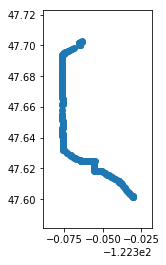

In [20]:
gdf.plot()
plt.show()

In [21]:
gdf.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coordinates
112745,11674003,47.601669,-122.330170,1,0.0,POINT (-122.33017 47.6016693)
112746,11674003,47.601719,-122.330269,2,30.0,POINT (-122.330269 47.6017189)
112747,11674003,47.601761,-122.330391,3,64.5,POINT (-122.330391 47.6017609)
112748,11674003,47.601830,-122.330498,4,100.1,POINT (-122.330498 47.6018295)
112749,11674003,47.601936,-122.330650,5,153.5,POINT (-122.33065 47.6019363)


In [22]:
stops_df = pd.read_csv('./data/source/gtfs_20180118/stops.txt')

In [23]:
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone
0,1000,NaN,Pine St & 9th Ave,NaN,47.613415,-122.332138,21,NaN,0,NaN,America/Los_Angeles
1,10000,NaN,NE 55th St & 43rd Ave NE,NaN,47.668575,-122.283653,1,NaN,0,NaN,America/Los_Angeles
2,10005,NaN,40th Ave NE & NE 51st St,NaN,47.665886,-122.284897,1,NaN,0,NaN,America/Los_Angeles
3,10010,NaN,NE 55th St & 39th Ave NE,NaN,47.668579,-122.285667,1,NaN,0,NaN,America/Los_Angeles
4,10020,NaN,NE 55th St & 37th Ave NE,NaN,47.668579,-122.288300,1,NaN,0,NaN,America/Los_Angeles


In [24]:
trips_df[trips_df.trip_id == 34921951]

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
21347,102581,21439,34921951,Downtown Seattle Uptown,LOCAL,1,4764891,20674043,0,101.0


In [25]:
# NEXT: to get stops for a route: route -> trips -> stop_times -> stops

In [26]:
d_trips = trips_df[trips_df.route_id == 102581]

In [27]:
d_trips[d_trips.direction_id == 0].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12146,102581,66726,34815377,Ballard Uptown,LOCAL,0,4759512,11674003,0,101.0
12147,102581,66726,34815378,Ballard Uptown,LOCAL,0,4759514,11674003,0,101.0
12148,102581,66726,34815379,Ballard Uptown,LOCAL,0,4759517,11674003,0,101.0
12149,102581,66726,34815380,Ballard Uptown,LOCAL,0,4759510,11674003,1,110.0
12150,102581,66726,34815381,Ballard Uptown,LOCAL,0,4759516,11674003,1,110.0


In [28]:
stop_times_df = pd.read_csv('./data/source/gtfs_20180118/stop_times.txt')

In [29]:
d_northbound_trip_ids = d_trips.loc[d_trips.direction_id == 0,'trip_id']

In [30]:
d_northbound_stop_times = stop_times_df[stop_times_df['trip_id'].isin(d_northbound_trip_ids)]

In [31]:
d_north_stop_ids = d_northbound_stop_times['stop_id'].unique()
d_north_stop_ids

array([ 1610,   538,   558,   578,   600,   605,  1690,  2332,  2360,
        2370, 14038, 14070, 14090, 14110, 14130, 14150, 14170, 14190,
       14200, 14230, 14250, 14280, 14300, 14322, 14340, 14360, 40050,
       28680])

In [32]:
d_north_stops = stops_df[stops_df.stop_id.isin(d_north_stop_ids)]
d_north_stops = d_north_stops.loc[:, ['stop_id', 'stop_lat', 'stop_lon']]
d_north_stops.set_index('stop_id', inplace=True)
d_north_stops['coordinates'] = list(zip(d_north_stops.stop_lon, d_north_stops.stop_lat))
d_north_stops['coordinates'] = d_north_stops['coordinates'].apply(Point)
d_north_stops = d_north_stops.loc[:, ['coordinates']]

In [33]:
d_north_stops.head()

,coordinates
stop_id,
14038,POINT (-122.361153 47.6246681)
14070,POINT (-122.371124 47.628788)
14090,POINT (-122.375481 47.6322517)
14110,POINT (-122.376099 47.63696289999999)
14130,POINT (-122.376114 47.64092249999999)


In [34]:
d_northbound_trip_ids.head()

12146    34815377
12147    34815378
12148    34815379
12149    34815380
12150    34815381
Name: trip_id, dtype: int64

In [35]:
d_northbound_locations = locations_df[locations_df.trip_id.isin(d_northbound_trip_ids)]
d_northbound_locations = d_northbound_locations[['route_id', 'trip_id', 'vehicle_id', 'vehicle_lat', 'vehicle_long']]

In [36]:
d_northbound_locations.shape

(77723, 5)

In [37]:
dline_df.shape

(167619, 8)

In [38]:
# that's good, our northbound D locations is approx 50% of previously calculated all D locations size

In [39]:
d_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long
timestamp_utc,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415


In [40]:
# now we need to find closest_stop_id from d_north_stops for all d_northbound_locations

In [41]:
d_north_stops.head()

,coordinates
stop_id,
14038,POINT (-122.361153 47.6246681)
14070,POINT (-122.371124 47.628788)
14090,POINT (-122.375481 47.6322517)
14110,POINT (-122.376099 47.63696289999999)
14130,POINT (-122.376114 47.64092249999999)


In [42]:
crs = {'init': 'epsg:4326'}
d_north_stops_gdf = gpd.GeoDataFrame(d_north_stops, crs=crs).set_geometry('coordinates')

def find_closest_stop_id(pnt):
    nearest = nearest_points(d_north_stops_gdf.geometry.unary_union, pnt)
    closest_coords = nearest[0]
    closest_stop = d_north_stops_gdf[d_north_stops_gdf['coordinates'] == closest_coords]
    return closest_stop.index[0]

In [43]:
# Check that the closest stop to the coordinates of the stop is the stop itself 
# pnt = Point(-122.344574, 47.694817)
pnt = Point(-122.361153, 47.6246681)
find_closest_stop_id(pnt)

14038

In [44]:
d_northbound_locations['coordinates'] = d_northbound_locations.apply(lambda x: Point(x['vehicle_long'], x['vehicle_lat']), axis=1)

In [45]:
# output cleared as tqdm generated 1000s of lines
d_northbound_locations['closest_stop_id'] = d_northbound_locations.progress_apply(lambda x: find_closest_stop_id(x['coordinates']), axis=1)

100%|██████████| 77723/77723 [01:40<00:00, 777.07it/s]


In [46]:
d_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates,closest_stop_id
timestamp_utc,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360


In [47]:
d_northbound_locations = d_northbound_locations.merge(d_north_stops,
                                                      how='left',
                                                      left_on='closest_stop_id', 
                                                      right_index=True, 
                                                      suffixes=('_vehicle', '_stop')
                                                     )
d_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop
timestamp_utc,,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170,POINT (-122.376045 47.6490974)
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332,POINT (-122.355347 47.62006760000001)
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332,POINT (-122.355347 47.62006760000001)
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200,POINT (-122.375977 47.6634369)
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360,POINT (-122.355316 47.623188)


## Compute the distance from the bus to the closest stop

We use the `geopy.distance` function `great_circle` to compute the distance between two points on Earth given their lattitude and longitude.

The `geopy.distance` function `geodesic` is more accurate (uses an ellipsoid model of the Earth rather than a sphere), but it gives similar answers and takes 10 times as long to run.

For comparison, we also try the simple approximation of the distance using the Pythagorean theorem (i.e. assuming flat Euclidean geometry rather than spherical). For some reason, the difference seems to greater when the points are closer together, which is the opposite of what I would expect...

In [48]:
#Write a function to compute the distance between two geographical points using geopy
def meters_between_points(point1, point2):
    #geopy needs the coordinates in (lat, long), whereas the Points are stored (long, lat)
    return great_circle((point1.y, point1.x), (point2.y, point2.x)).meters

In [49]:
#From timestamp 2017-12-31 23:58:45
bus_coordinates = Point(-122.3761367797852, 47.64912033081055)
stop_coordinates = Point(-122.376045, 47.6490974)
meters_between_points(bus_coordinates, stop_coordinates)

7.33270147592989

In [53]:
#Compare with Euclidean approximation - 10.5 meters vs. 7.3 meters
EARTH_RADIUS_METERS = 6371.009 * 1000
degree_dist = bus_coordinates.distance(stop_coordinates)
np.radians(degree_dist) * EARTH_RADIUS_METERS

10.519167197649717

In [54]:
#From timestamp 2018-01-01 00:00:25
bus_coordinates = Point(-122.376220703125, 47.65950775146485)
stop_coordinates = Point(-122.375977, 47.6634369)
meters_between_points(bus_coordinates, stop_coordinates)

437.28304660827376

In [55]:
#Compare with Euclidean approximation - 437.74 meters meters vs. 437.28 meters
degree_dist = bus_coordinates.distance(stop_coordinates)
np.radians(degree_dist) * EARTH_RADIUS_METERS

437.74158066126256

In [56]:
#Compute the distance from the bus to the closest stop using geopy.distance.great_circle
d_northbound_locations['meters_to_stop'] = (
    d_northbound_locations.progress_apply(lambda df:
                                 meters_between_points(df['coordinates_vehicle'], df['coordinates_stop']),
                                 axis=1
                                )
)
d_northbound_locations.head()

100%|██████████| 77723/77723 [00:07<00:00, 10552.31it/s]


,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop,meters_to_stop
timestamp_utc,,,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170,POINT (-122.376045 47.6490974),7.332701
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332,POINT (-122.355347 47.62006760000001),6.837902
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332,POINT (-122.355347 47.62006760000001),7.454585
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200,POINT (-122.375977 47.6634369),437.283047
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360,POINT (-122.355316 47.623188),7.445441


In [57]:
#Compute the Euclidean approximation of the distance from the bus to the closest stop for comparison

EARTH_RADIUS_METERS = 6371.009 * 1000

d_northbound_locations['euclid_meters_to_stop'] = (
    d_northbound_locations.progress_apply(lambda df: EARTH_RADIUS_METERS *
                                 np.radians(df['coordinates_vehicle'].distance(df['coordinates_stop'])),
                                 axis=1
                                )
)
d_northbound_locations.head()

100%|██████████| 77723/77723 [00:02<00:00, 26135.52it/s]


,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop,meters_to_stop,euclid_meters_to_stop
timestamp_utc,,,,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170,POINT (-122.376045 47.6490974),7.332701,10.519167
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332,POINT (-122.355347 47.62006760000001),6.837902,10.144597
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332,POINT (-122.355347 47.62006760000001),7.454585,10.570090
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200,POINT (-122.375977 47.6634369),437.283047,437.741581
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360,POINT (-122.355316 47.623188),7.445441,11.046591


9.460100973296164e-05

10.519167197649715

In [9]:
np.radians(degree_dist) * 6371.0087714150598 * 1000

10.519166820233327

In [10]:
np.radians(degree_dist) * 6356.7523142 * 1000

10.495627996619776

In [47]:
e_northbound_locations = e_northbound_locations[['route_id', 'trip_id', 'vehicle_id','coordinates', 'closest_stop_id']]

In [48]:
e_northbound_locations.index.names = ['timestamp_utc']
e_northbound_locations.head()

,route_id,trip_id,vehicle_id,coordinates,closest_stop_id
timestamp_utc,,,,,
2017-12-31 23:58:46,102615,34922164,6211,POINT (-122.3445739746094 47.69481658935547),7750
2017-12-31 23:59:04,102615,34922180,6088,POINT (-122.3435592651367 47.61811828613281),6235
2017-12-31 23:59:05,102615,34922131,6054,POINT (-122.3424072265625 47.77417755126953),16103
2017-12-31 23:59:22,102615,34922163,6062,POINT (-122.3457260131836 47.75570297241211),75881
2018-01-01 00:00:08,102615,34922131,6054,POINT (-122.3424072265625 47.77417755126953),16103


In [49]:
e_northbound_locations.to_hdf('./data/intermed/e_northbound_locations_2018-01.h5', key='e_northbound_locations_gdf', mode='w')

/Users/aps/miniconda3/envs/realtime_buses/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['coordinates']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
